In [5]:
import os
import numpy 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')

from trainer import Trainer
from model import Net
from dataloader import ShapeDataset
import torch
from torch.utils.data import DataLoader



In [42]:
def get_data_to_df(path):
    df = {
        'filename': [],
        'label': []
    }
    
    for folder in os.listdir(path):
        for img in os.listdir(os.path.join(path, folder)):
            df['filename'].append(os.path.join(path, folder, img))
            df['label'].append(folder)
            
    df = pd.DataFrame(df).sample(frac=1.0)
    df_train, df_val = train_test_split(df, test_size=0.2)
    print(f"Train: {len(df_train)}")
    print(f"Val: {len(df_val)}")
    
    return df_train, df_val

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_root = '/scratch/fk/shapes'
batch_size = 64

df_train, df_val = get_data_to_df(data_root)

train_dataset = ShapeDataset(df=df_train, type='train')
val_dataset = ShapeDataset(df=df_val, type='val')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

a = next(iter(train_loader)).cpu().numpy()
# print(a.shape)   
# plt.imsave('./temp/0.png', a[0].cpu().permute(1, 2, 0).numpy())

model = Net(device=device)
model.load_state_dict(torch.load('/scratch/fk/checkpoints/vae_shapes_99.pth'))
model = model.to(device)

Train: 4403
Val: 1101
Encoder created
Decoder created


(64, 1, 100, 100)


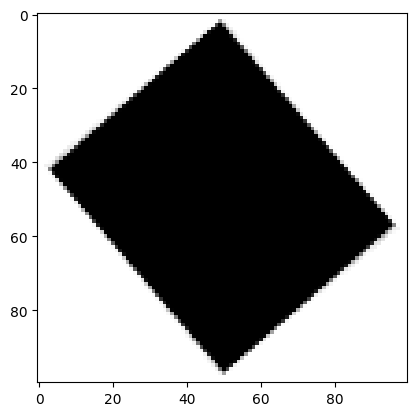

In [109]:
img1 = a.copy()
print(img1.shape)
plt.imshow(img1[13][0], cmap='binary')
with torch.no_grad():
    y_pred, mean, logvar = model(torch.tensor(img1).to(device))

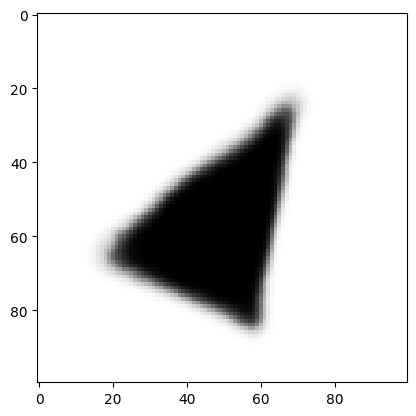

In [149]:
plt.imshow(y_pred.cpu().numpy()[47][0], cmap='binary')

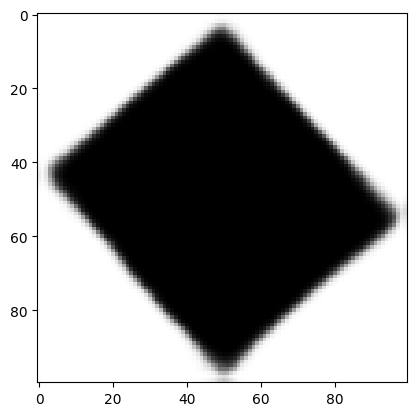

In [110]:
plt.imshow(y_pred.cpu().numpy()[13][0], cmap='binary')

In [73]:
mean.shape

torch.Size([64, 16])

In [150]:
n1, n2 = 13, 47

mean1, logvar1 = mean[n1], logvar[n1]
mean2, logvar2 = mean[n2], logvar[n2]
t = torch.linspace(0, 1, 64).to(device)
mean_t = torch.stack([mean1 * (1 - i) + mean2 * i for i in t])
logvar_t = torch.stack([logvar1 * (1 - i) + logvar2 * i for i in t])

mean_t.shape, logvar_t.shape

(torch.Size([64, 16]), torch.Size([64, 16]))

In [151]:
with torch.no_grad():
    z = model.reparam(mean_t, logvar_t)
    out = model.decoder(z)

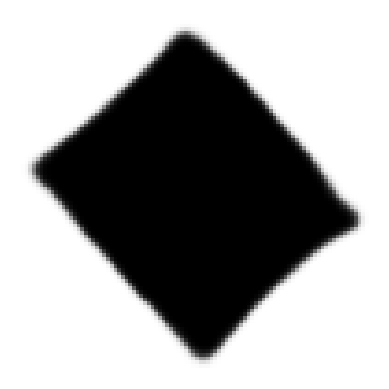

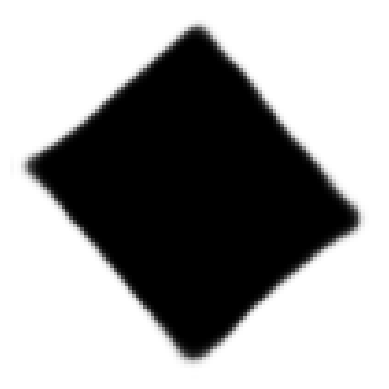

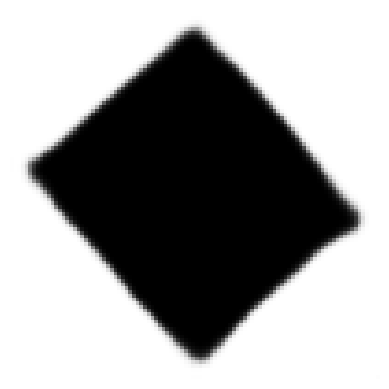

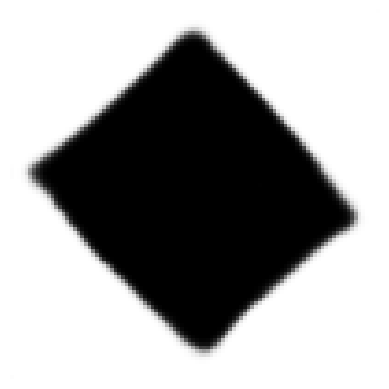

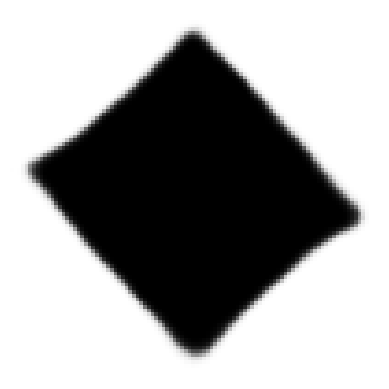

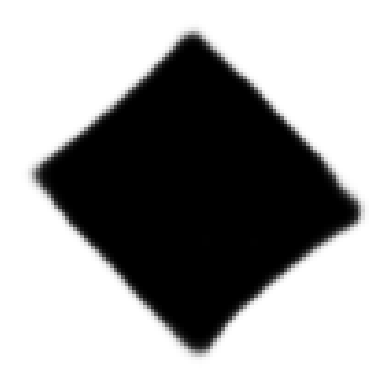

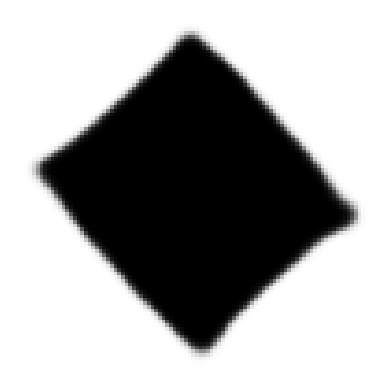

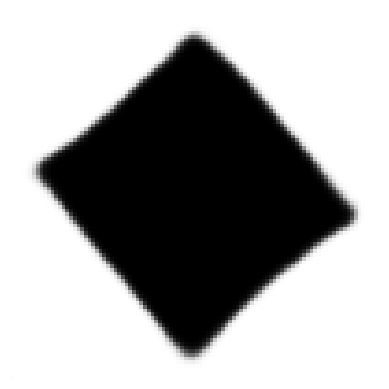

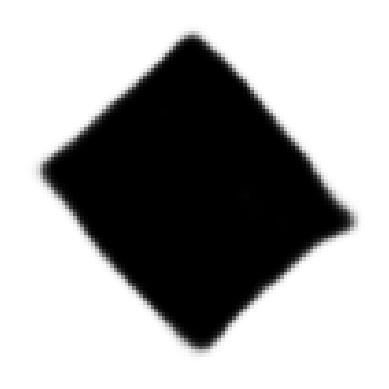

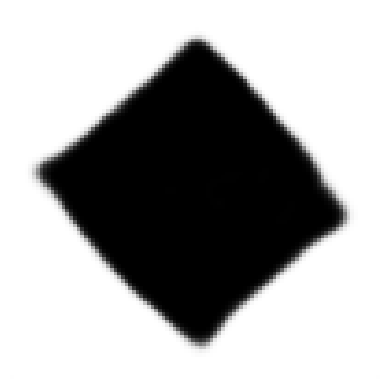

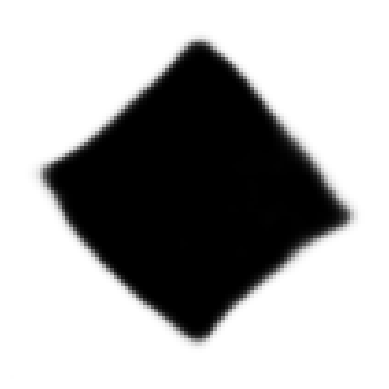

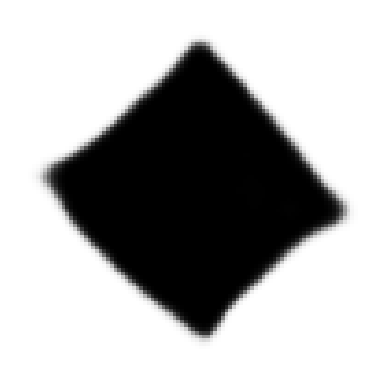

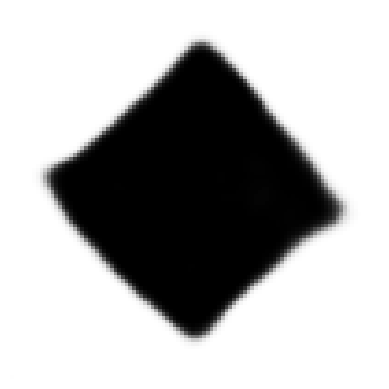

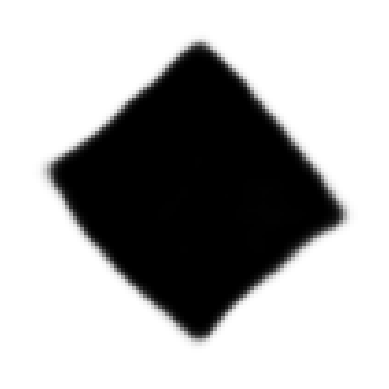

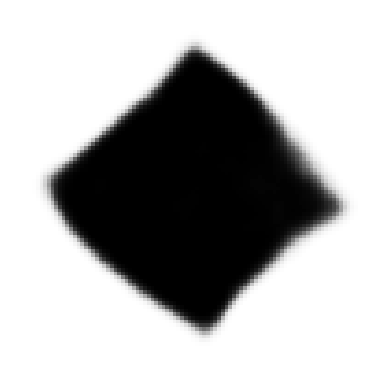

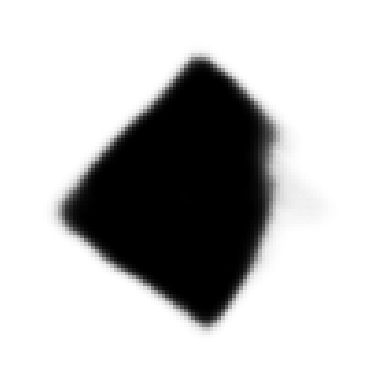

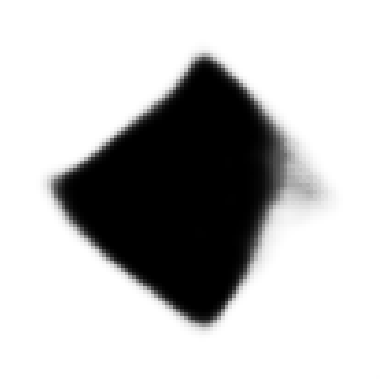

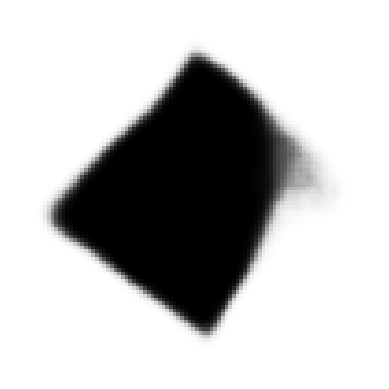

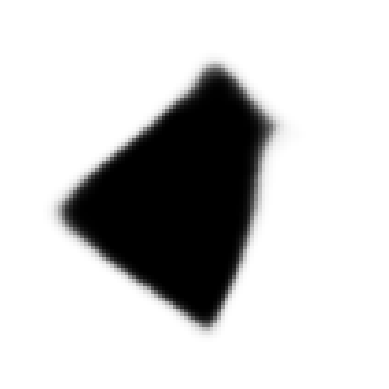

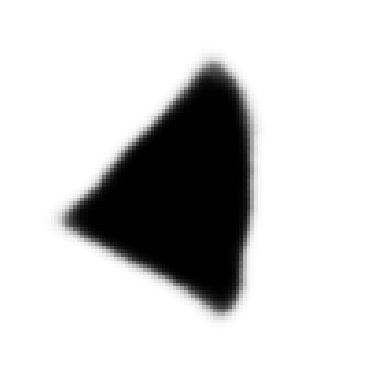

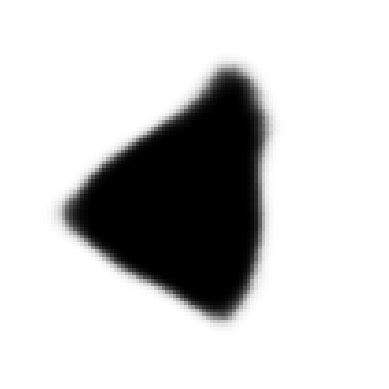

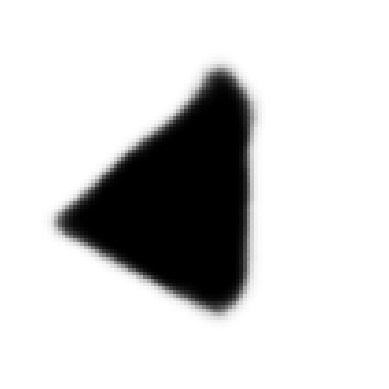

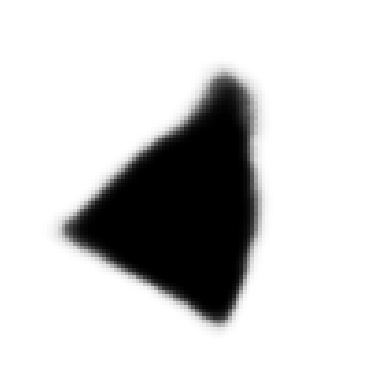

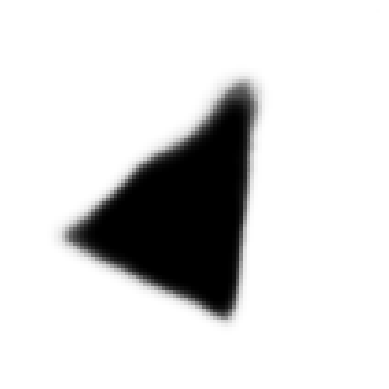

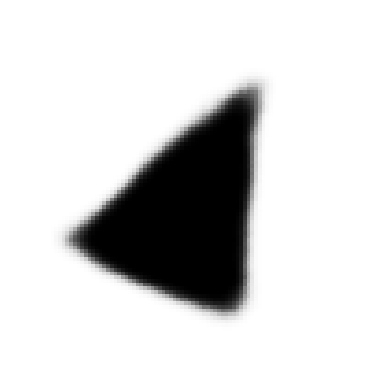

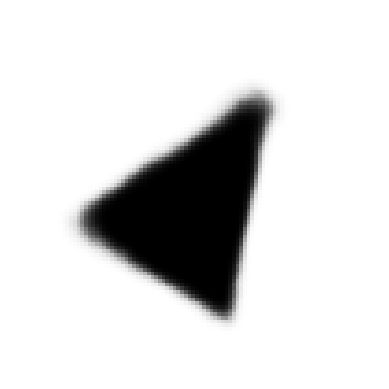

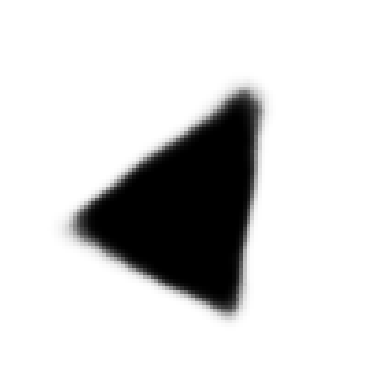

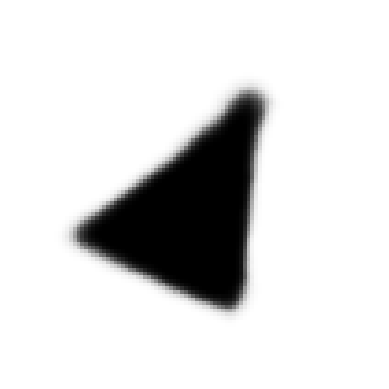

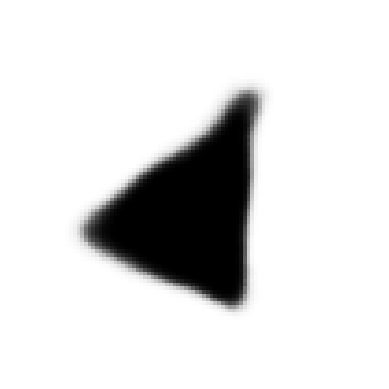

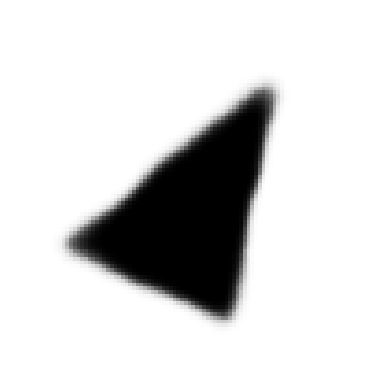

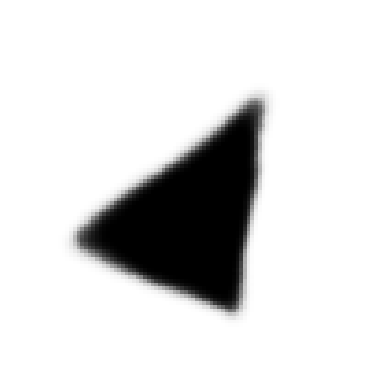

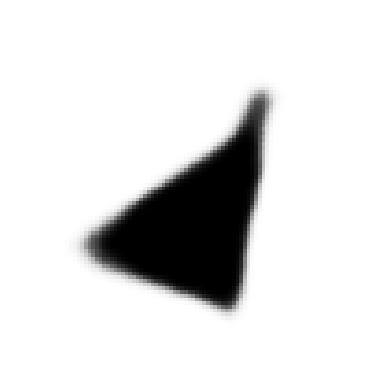

In [152]:
os.makedirs('../temp/gif/13_47', exist_ok=True)
for i in range(0, len(z), 2):
    plt.imshow(out[i][0].cpu().numpy(), cmap='binary')
    plt.axis('off')
    plt.savefig(f'../temp/gif/13_47/{i}.png')
    plt.show()